In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import myPreprocessors as mypp #nuestra librerías de transformaciones.

import joblib

### 1. Extraer dateframe

In [2]:
dataTrain = pd.read_csv("train.csv")
dataTrain.head()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,9744,-121.65,36.77,15,2191,358.0,1150,330,4.7969,227500.0,<1H OCEAN
1,13893,-116.27,34.13,37,452,109.0,184,59,3.7292,65800.0,INLAND
2,18277,-122.07,37.34,35,1172,184.0,512,175,7.3561,500001.0,<1H OCEAN
3,16176,-122.39,37.74,52,126,24.0,37,27,10.2264,225000.0,NEAR BAY
4,8843,-118.38,34.09,28,4001,1352.0,1799,1220,2.5784,272900.0,<1H OCEAN


##### Se revisó que tipo de dato se tiene en cada columna.

In [3]:
dataTrain.dtypes

id                      int64
longitude             float64
latitude              float64
housing_median_age      int64
total_rooms             int64
total_bedrooms        float64
population              int64
households              int64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

#### 2. Identificación de nulos

In [4]:
col_nulos = [col for col in dataTrain.columns if(dataTrain[col].isnull().mean()>0)]
col_nulos

['total_bedrooms']

##### Unicamente se obtuvo una variable con nulos, la cual fue el total de dormitorios. Adicional se observa que la cantidad de nulos es de 0.94%, por lo cual se le puede dar tratamiento.

In [5]:
dataTrain['total_bedrooms'].isnull().mean()

0.009482937634110887

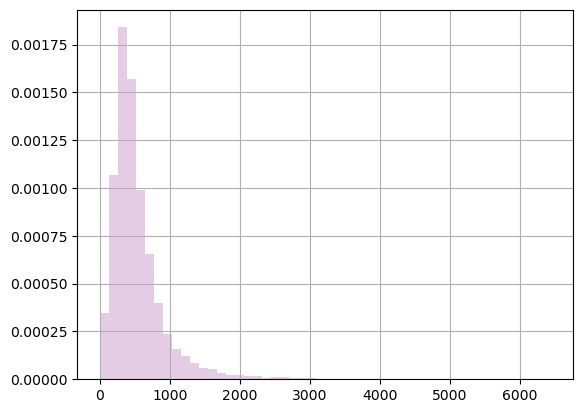

In [6]:
dataTrain['total_bedrooms'].hist(bins=50, density=True, color='purple', alpha=0.2)
plt.show()

#### 3. Train Test Split para Entrenamiento y Prueba

##### Se dividió la data en 4 para tener los datos de entrenamiento y de prueba, tanto para las variables explicativas como la Y.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    dataTrain.drop(['id', 'median_house_value'], axis=1),
    dataTrain['median_house_value'],
    test_size=0.3,
    random_state=2022)

#### 3. Configuración del Pipeline

In [8]:
#Imputación de variables numéricas
NUMERICAL_VARS_WITH_NA = ['total_bedrooms']

#Variables para codificación por frecuencia (no ordinal)
CATEGORICAL_VARS = ['ocean_proximity']

#Variables a utilzar en el entrenamiento
FEATURES = [
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'ocean_proximity'
]

In [9]:
X_train = X_train[FEATURES]

In [10]:
y_train = np.log(y_train)
y_test = np.log(y_test)

#### 4. Construcción del Pipeline

##### Dentro del Pipeline se trabajará la imputación para la columna con nulos utilizando la media para llenar los espacios, se codificará la columna con datos categoricos, posteriormente se realizará el scaling, para homogenizar los valores de todas las columnas y por último manejar la regularización de los datos a través del modelo lasso.

In [11]:
housePrice_pipeline = Pipeline([
    
    #=========== IMPUTACIONES ===============

        #3. Indicador faltane en variables numericas para imputación
    ('missing_indicator_numeric',
        AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)
    ),
    
    #4. Imputación de variables numéricas
    ('mean_imputation',
        MeanMedianImputer(imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA)
    ),

    #============= CODIFICACIÓN DE VARIABLES CATEGORICAS NOMINALES ==================
    ('rare_label_encoder',
        RareLabelEncoder(n_categories=1, tol=0.01, variables=CATEGORICAL_VARS)
    ),
    
    ('categorical_encoder',
        OrdinalEncoder(encoding_method='ordered', variables=CATEGORICAL_VARS)
    ),

    #=============== SCALER ============
    ('scaler',
        MinMaxScaler()
    ),
    
    ('modelo_lasso', 
         Lasso(alpha=0.01, random_state=2022)
    )
])
    

##### Utilizando el pipeline se realiza el proceso de entrenamiento a través de la función fit

In [13]:
housePrice_pipeline.fit(X_train, y_train)

Pipeline(steps=[('missing_indicator_numeric',
                 AddMissingIndicator(variables=['total_bedrooms'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['total_bedrooms'])),
                ('rare_label_encoder',
                 RareLabelEncoder(n_categories=1, tol=0.01,
                                  variables=['ocean_proximity'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['ocean_proximity'])),
                ('scaler', MinMaxScaler()),
                ('modelo_lasso', Lasso(alpha=0.01, random_state=2022))])

In [14]:
X_test = X_test[FEATURES]

##### Se realiza el proceso de predicción con la fracción de la data para prueba

In [15]:
preds = housePrice_pipeline.predict(X_test)

##### Por último se realiza el calculo del RMSE

In [16]:
rmseTest = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(preds)))
rmseTest

86077.02825053826

In [17]:
np.min(np.exp(y_train)), np.max(np.exp(y_train))

(14999.00000000001, 500000.99999999977)

In [18]:
rmseTest / (np.max(np.exp(y_train)) - np.min(np.exp(y_train)))

0.17747767689728766

##### Se podría concluir que el modelo tiene un buen desempeño en la predicción de los valores de salida en comparación con la variación total de los valores.

In [19]:
#guardamos pipeline para uso en producción.
joblib.dump(housePrice_pipeline, 'housePrice_pipeline.pkl')

['housePrice_pipeline.pkl']

In [20]:
joblib.dump(FEATURES, 'FEATURES.pkl')

['FEATURES.pkl']